# Exercício 8 - Clusterização e Classificação

Você foi escolhido o melhor cientista de dados de sua empresa e agora terá que fazer um trabalho para o governo em um dataset secreto, onde não se sabe o que representam cada coluna.  

O governo não sabe como classificar os registros desse conjunto, logo foi sugerido uma clusterização que dará origem as classes do problema para que quando novos registros forem adicionar a bases, estes sejam automaticamente classificados por um classificador previamente
treinado.  

Logo se a clusterização for ruim, isso poderá comprometer toda a classificação.  

Adicionalmente o Governo também deseja um Regressor que a partir dele construirá um simulador web informando as características e o regressor treinado calculará uma saída contínua baseado na característica V2.  


> **Pré-Processamento** > **Clusterização** > **Classificação** > **Regressão**

O que deve ser entregue:  

Um documento (.doc, .pdf ou notebook) explicando TODOS os passos da solução.  

É permitido usar todas as técnicas vistas em sala de aula.  

Lembrando que são 3 principais componentes do trabalho:  
 - Clusterização  
 - Classificação  
 - Regressão  

O pré-processmanto dos dados é fundamental.  

Faça a plotagem da clusterização.  
Faça a plotagem da Matriz de confusão e analise os resultados.  
Faça a plotagem dos resultados encontrados com os regressores utilizados  

O Conjunto de dados está disponível no repositório da disciplina com o nome TrabalhoEx8.csv 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_csv('bases/TrabalhoEx8.csv', engine='python', sep=';')
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,-122.23,452600.0,129.0,41.0,880.0,D,126.0,322.0,83.252,37.88
1,-122.22,358500.0,1106.0,21.0,7099.0,D,1138.0,2401.0,83.014,37.86
2,-122.24,352100.0,190.0,52.0,1467.0,D,177.0,496.0,72.574,37.85
3,-122.25,341300.0,235.0,52.0,1274.0,D,219.0,558.0,56.431,37.85
4,-122.25,342200.0,280.0,52.0,1627.0,D,259.0,565.0,38.462,37.85


# Pré-processamento
Analisamos o dataset importado e fazemos o tratamento de dados adequado

In [3]:
# Analisando se existem valores faltantes
print(data.info(),'\n')

# Analisando a composição das variáveis numéricas
print(data.describe(), '\n')

# Valores da coluna V6
print('V6')
print(data.V6.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      20640 non-null  float64
 1   V2      20640 non-null  float64
 2   V3      20433 non-null  float64
 3   V4      20640 non-null  float64
 4   V5      20640 non-null  float64
 5   V6      20640 non-null  object 
 6   V7      20640 non-null  float64
 7   V8      20640 non-null  float64
 8   V9      20640 non-null  float64
 9   V10     20640 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None 

                 V1             V2            V3            V4            V5  \
count  20640.000000   20640.000000  20433.000000  20640.000000  20640.000000   
mean    -119.569704  206855.816909    537.870553     28.639486   2635.763081   
std        2.003532  115395.615874    421.385070     12.585558   2181.615252   
min     -124.350000   14999.000000      1.000000      1.000000      

In [4]:
# Apenas a variável V3 possui valores faltantes (aproximadamente 1%)
# Substituindo o valores faltantes com o valor médio
data['V3'] = data['V3'].fillna(data['V3'].mean())

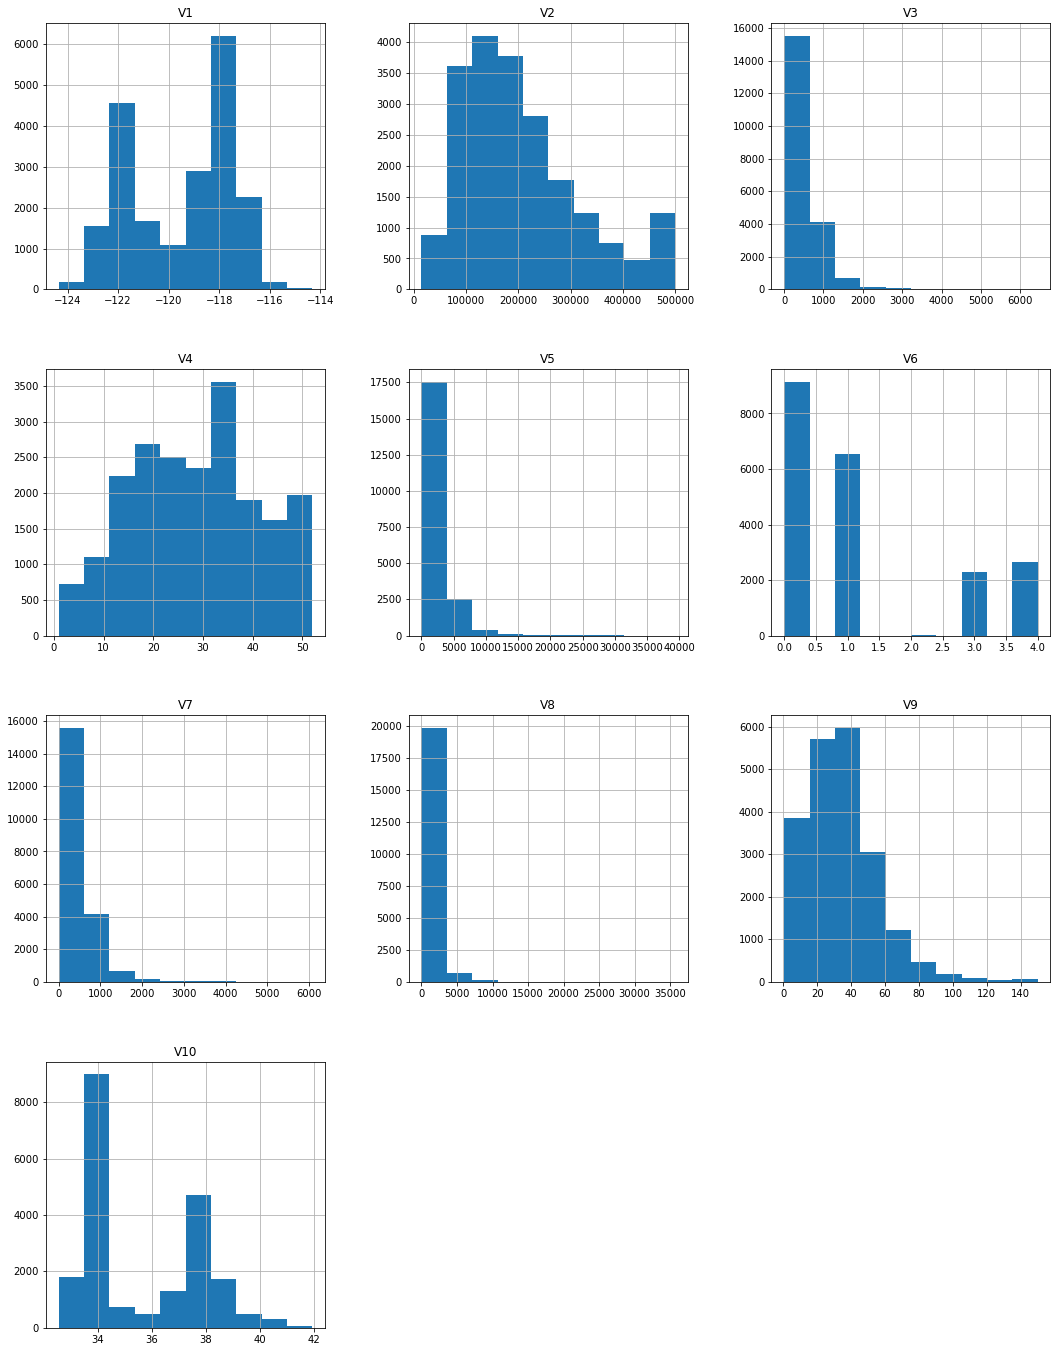

In [5]:
data_hist = data.copy()

# Convertendo os valores categóricos para números apenas pra visualizarmos como histograma
data_hist['V6'] = LabelEncoder().fit_transform(data['V6'])

data_hist.hist(figsize=(18,24));

In [6]:
# Como desconhecemos a natureza da variávvel categórica V6, utilizamos a abordagem One Hot Enconding
# Criando variáveis dummy a partir da variável V6
dummy_V6 = pd.get_dummies(data['V6'], drop_first=True, prefix='V6')
data = data.drop(columns=['V6'])

data_norm = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns)

data_norm = pd.concat([ data_norm.loc[:,:'V5'], dummy_V6, data_norm.loc[:,'V7':] ], axis=1)

# Clusterização  
Apartir do dataset normalizado, vamos efetuar a clusterização utolizando o método K-Means.  

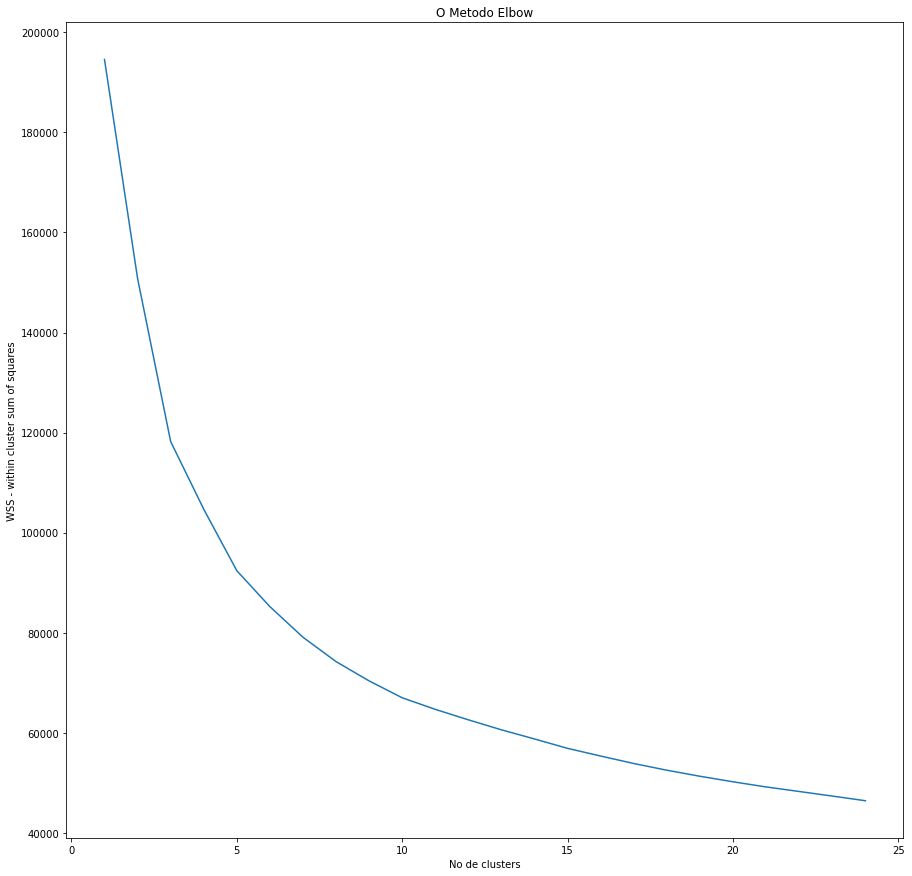

In [7]:
inertias =[]
range_n_clusters = range(1, 25)
for i in range_n_clusters:
    kmeans = KMeans(n_clusters = i, max_iter=50).fit(data_norm)
    inertias.append(kmeans.inertia_)

plt.figure(2, figsize=(15,15))
plt.plot(range_n_clusters, inertias)
plt.title('O Metodo Elbow')
plt.xlabel('No de clusters')
plt.ylabel('WSS - within cluster sum of squares')
plt.show()

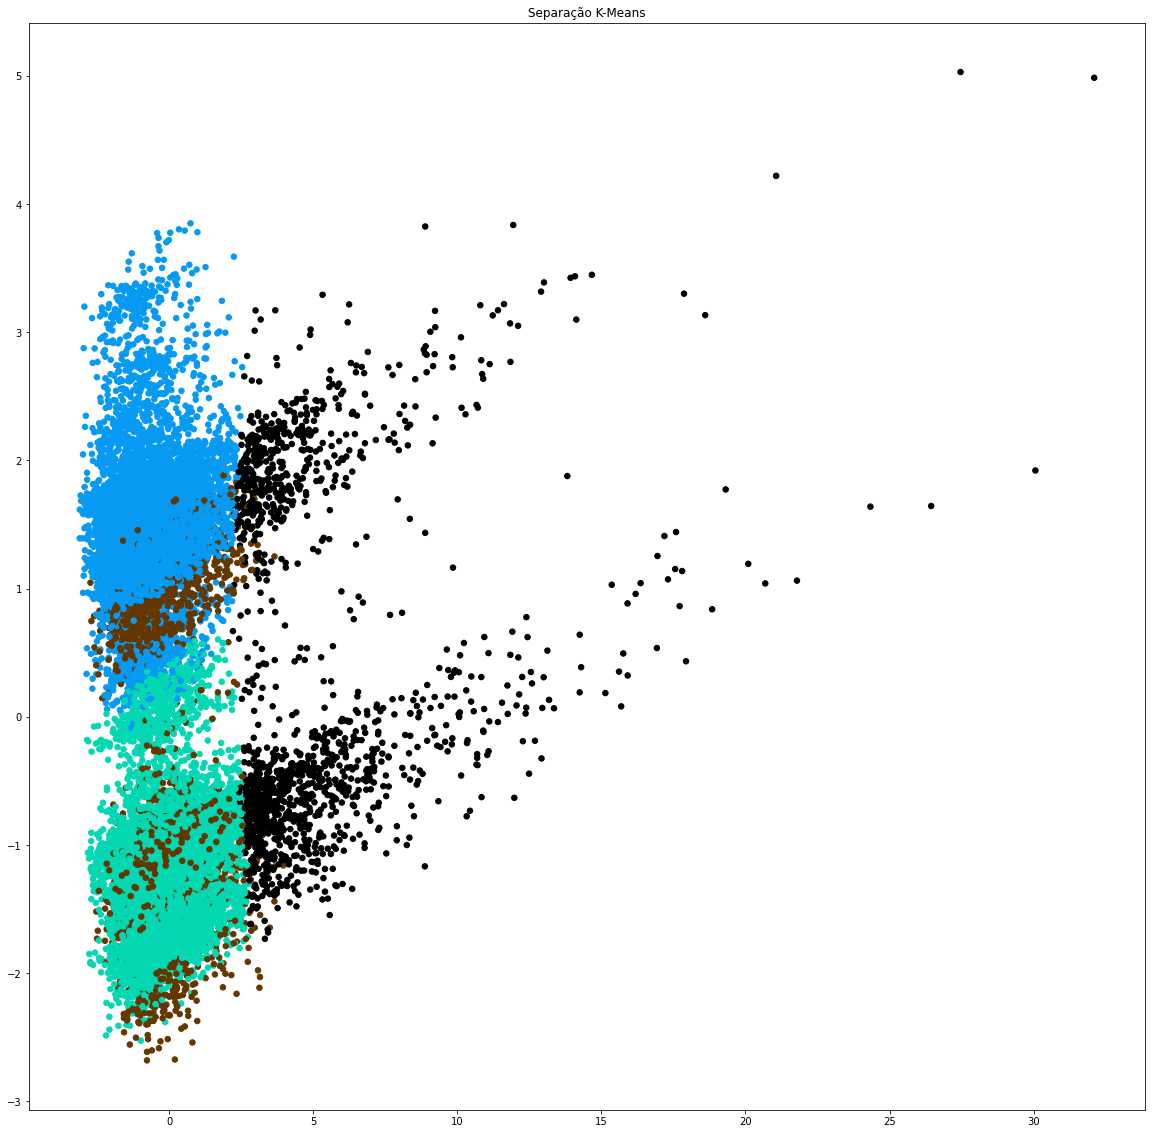

In [8]:
kdata = data_norm.copy()
# A partir do gráfico acima visualmente percebemos o que o númedo ideal de clusters estaria entre 4 e 6, escolhemos o 4 para nosso caso.
kmeans = KMeans(n_clusters = 4, random_state=42)
kmeans.fit(kdata)

# Visualizando o gráfico de forma simplificada em 2 dimensões.
pca = PCA(n_components=2).fit_transform(kdata)

xkcd = np.array(['#04d8b2', '#069af3', '#000000', '#653700', '#fc5a50', 
    '#ed0dd9', '#dbb40c', '#15b01a', '#380282', '#c20078', 
    '#a9561e', '#c5c9c7', '#ec2d01', '#9a0eea', '#b0dd16'])
vectorizer = np.vectorize(lambda x: xkcd[x % len(xkcd)])

plt.figure(3, figsize=(20,20))
plt.scatter(pca[:,0], pca[:,1], c=vectorizer(kmeans.labels_), s=30)

plt.title('Separação K-Means')
plt.show();

# Classificação  
Utilizando as labels da sessão anterior, podemos efetuar a classificação do dataset.

In [9]:
# Separando o dataset entre treino e teste 
X_train, X_test, y_train, y_test = train_test_split(kdata, kmeans.labels_, test_size = .2, random_state=42)

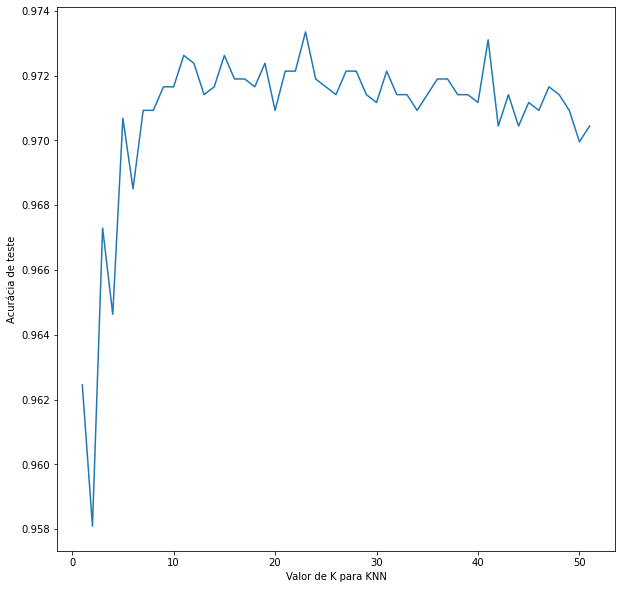

In [10]:
# testa do K=1 até K=52
k_range = range(1, 52)

# Lista todas as acurácias
scores = []

# Faz um loop de 1 a 52 armazena no dicionário scores
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

df_scores = pd.DataFrame(data = {'K': k_range, 'score': scores})   
# print(df_scores,'\n')

# Plota os valores de acc. em função do valor escolhido de K
plt.figure(1, figsize=(10,10))
plt.plot(k_range, scores)
plt.xlabel('Valor de K para KNN')
plt.ylabel('Acurácia de teste')
plt.show();

Melhor K encontrado: 23
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1824
           1       0.97      0.99      0.98      1434
           2       0.99      0.93      0.96       294
           3       0.97      0.93      0.95       576

    accuracy                           0.97      4128
   macro avg       0.98      0.96      0.97      4128
weighted avg       0.97      0.97      0.97      4128


Acurácia: 0.9733527131782945 



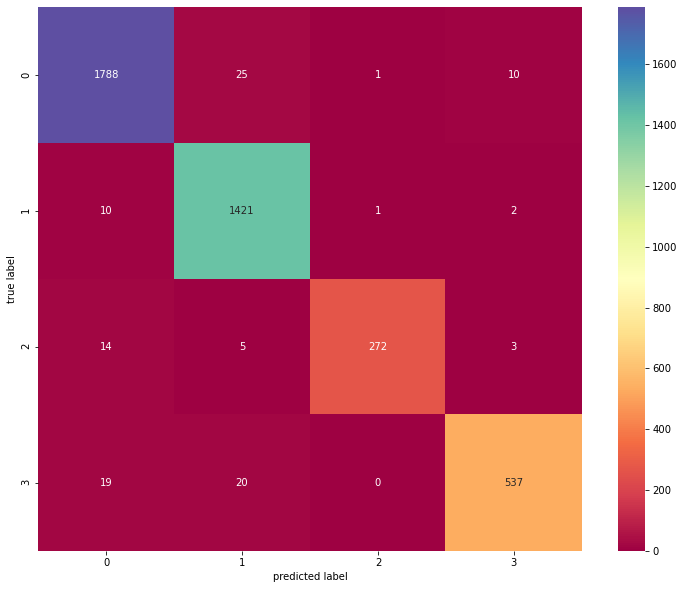

In [11]:
#Avaliando a melhor configuração de KNN
k = int(df_scores.loc[df_scores.score.idxmax()].K)
print('Melhor K encontrado:', k)

best_KNN = KNeighborsClassifier(n_neighbors=k)
best_KNN.fit(X_train, y_train)
y_pred = best_KNN.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print('\nAcurácia:', accuracy_score(y_test, y_pred), '\n')

fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', 
            ax = ax, cmap="Spectral", 
            xticklabels=set(kmeans.labels_),
            yticklabels=set(kmeans.labels_) )
ax.set_ylabel('true label')
ax.set_xlabel('predicted label')
plt.show();

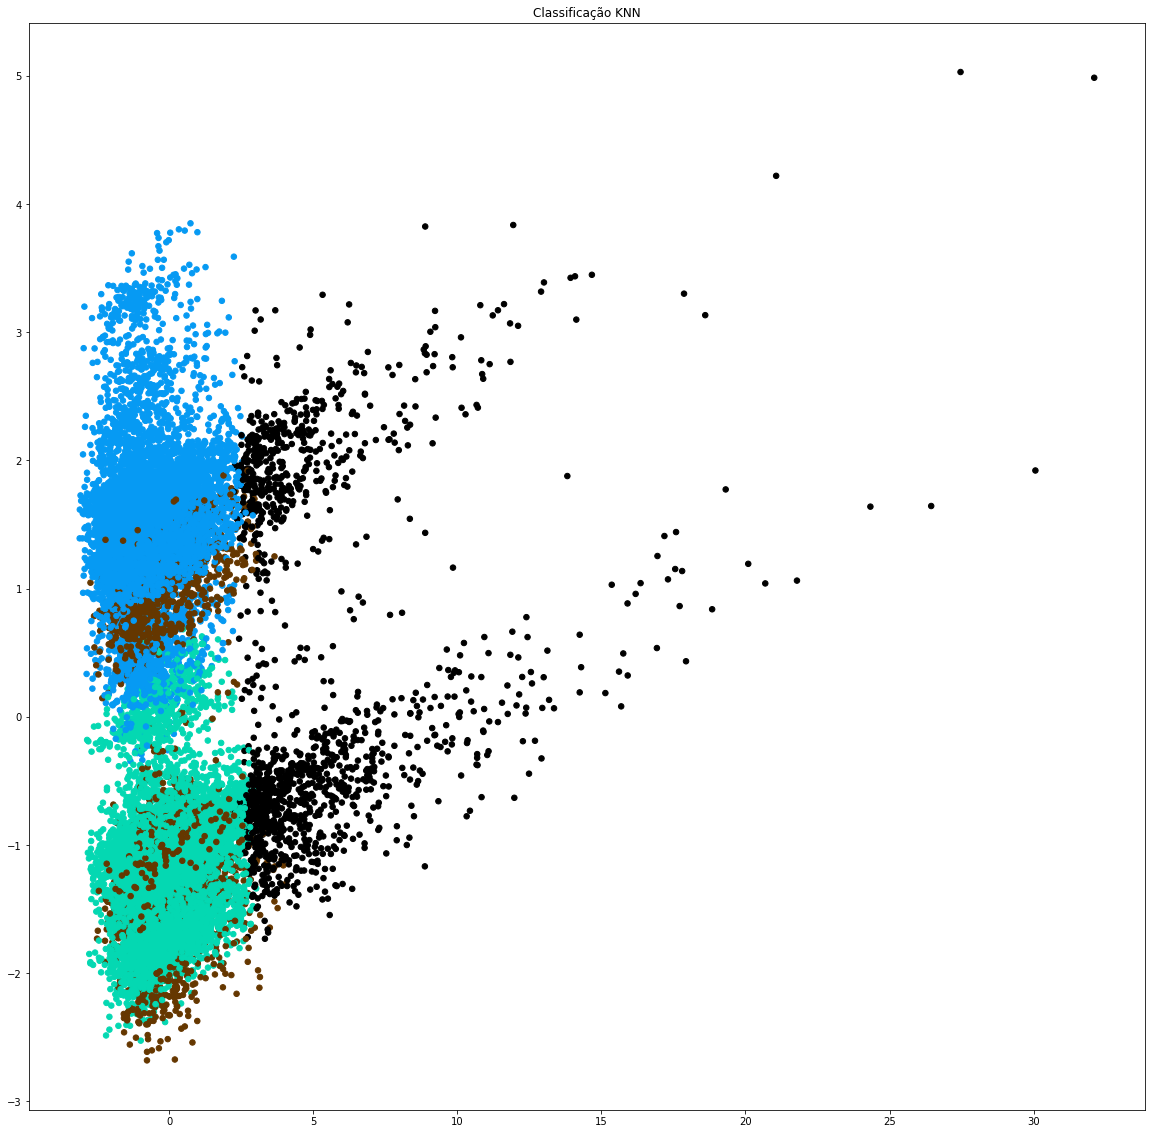

In [12]:
# Visualizando o gráfico de forma simplificada em 2 dimensões.
y_pred_full = best_KNN.predict(kdata)

plt.figure(3, figsize=(20,20))
plt.scatter(pca[:,0], pca[:,1], c=vectorizer(y_pred_full), s=30)

plt.title('Classificação KNN')
plt.show();

# Regressão  
Com os dois processos terminados, criamos agora a regressão para predizer o valor de **V2**

In [13]:
# Adicionando a classificação ao dataset como variáveis dummy

dummy_label = pd.get_dummies(y_pred_full, drop_first=True, prefix='label')

data_norm = pd.concat([data_norm, dummy_label], axis=1)

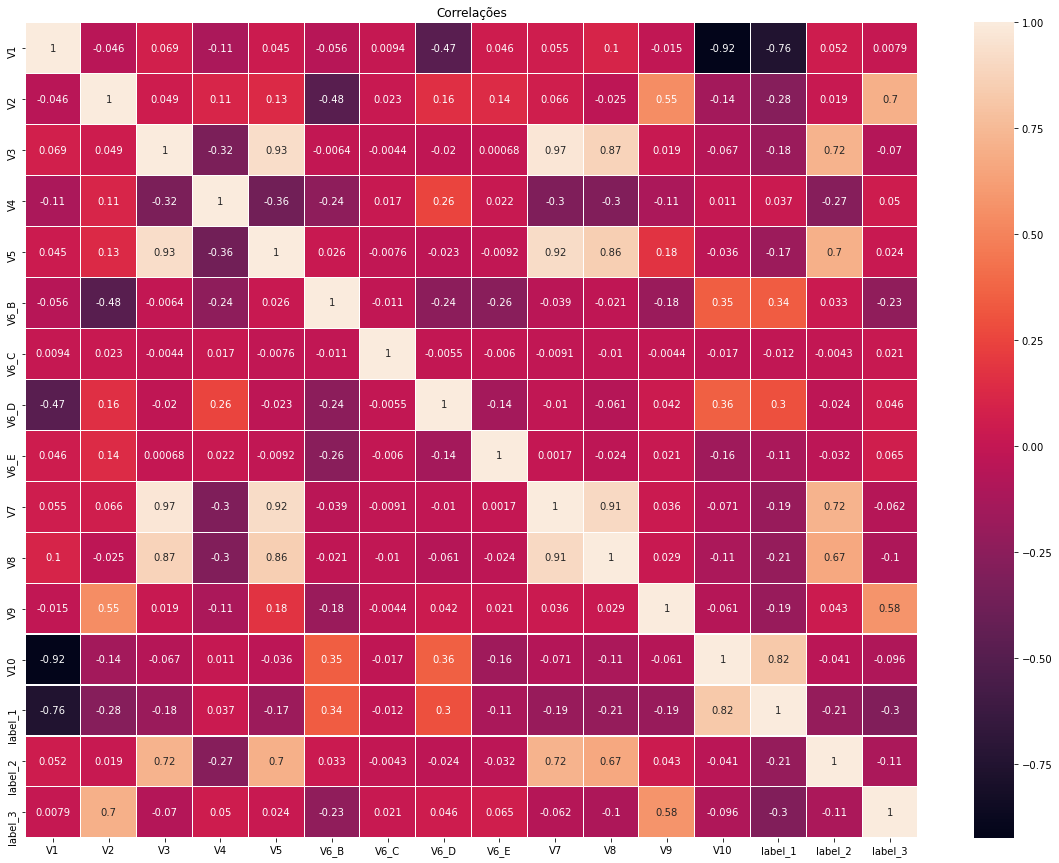

In [14]:
# Visualizando a correlação entre as variáveis 

plt.figure(figsize=(20,15))
sns.heatmap(data_norm.corr(), linewidths=.1, annot=True).set_title("Correlações");

LR: -0.318737 (0.015227)
RD: -0.318739 (0.015230)
LS: -1.004014 (0.033316)
EL: -0.965887 (0.033389)
KNN: -0.224557 (0.018607)
DTR: -0.269024 (0.015420)
RF: -0.138127 (0.009990)
ADA: -0.410291 (0.036920)


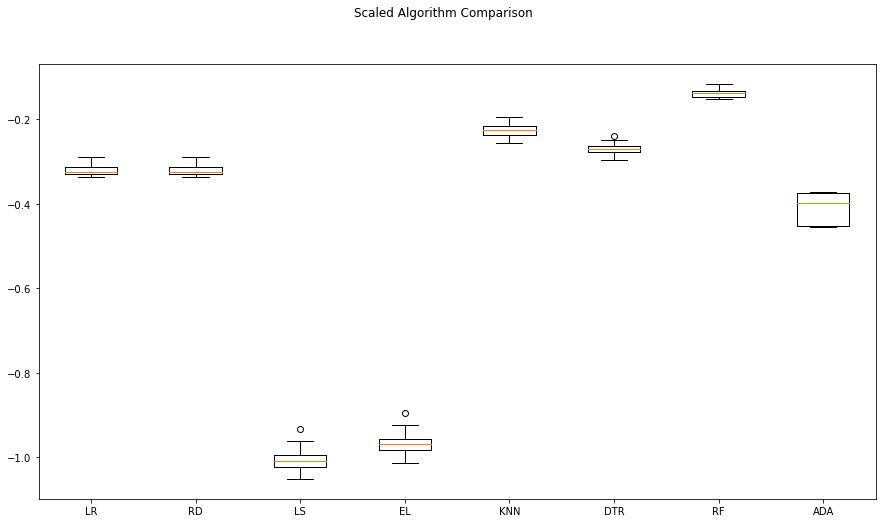

In [24]:
X = data_norm.drop(columns=['V2'])
Y = data_norm['V2']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


pipelines = [
    ('LR',  Pipeline([('LR', LinearRegression())])),
    ('RD',  Pipeline([('RD', Ridge())])),
    ('LS',  Pipeline([('LS', Lasso())])),
    ('EL',  Pipeline([('EL', ElasticNet())])),
    ('KNN', Pipeline([('KNN', KNeighborsRegressor())])),
    ('DTR', Pipeline([('DTR', DecisionTreeRegressor())])),
    ('RF',  Pipeline([('RF', RandomForestRegressor())])),
    ('ADA', Pipeline([('ADA', AdaBoostRegressor())]))
]

results = []
names = []

# Avaliação dos Pipelines
# Root Mean Square error method

num_folds = 10
RMS = 'neg_mean_squared_error'

for name, model in pipelines:
	kfold = KFold(n_splits=num_folds, random_state=42, shuffle = True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=RMS)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)


# Comparando os Algorítimos
fig = plt.figure(figsize=(15,8))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [16]:
# Segundo a comparação de acima, temos que o melhor algoritmo para este dataset foi a regrssão via Ramdom Forest.
# Buscando pelos melhores hiperparametros 
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3, 17, 2),
            'n_estimators': (10, 50),
        },
        cv=5, 
        scoring='neg_mean_squared_error', 
        n_jobs=-1)

grid_result = gsc.fit(X, Y)
best_params = grid_result.best_params_

print('Melhores hiperparametros encontrados', 
      'max_depth: {} e n_estimators: {}'.format(best_params["max_depth"],best_params["n_estimators"]))

Melhores hiperparametros encontrados max_depth: 15 e n_estimators: 50


In [17]:
# Executando a regressão completa com os dados de treino
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], 
    n_estimators=best_params["n_estimators"], 
    random_state=42)

rfr.fit(X_train, y_train)
predictions = rfr.predict(X_test)

#MAE
print("Erro médio absoluto", metrics.mean_absolute_error(y_test, predictions))
#MSE
mse = metrics.mean_squared_error(y_test, predictions)
print("Erro médio quadrático", mse)
#RMSE
rmse = math.sqrt(mse)
print("Raiz do erro médio quadrático", rmse)

Erro médio absoluto 0.2514895670272885
Erro médio quadrático 0.13965948411476117
Raiz do erro médio quadrático 0.37371042815897065


In [22]:
print('R2 score:', metrics.r2_score(data_norm['V2'], full_predictions))
print('Explain variance score:', metrics.explained_variance_score(data_norm['V2'], full_predictions))

R2 score: 0.9386650951374361
Explain variance score: 0.9386655636407331


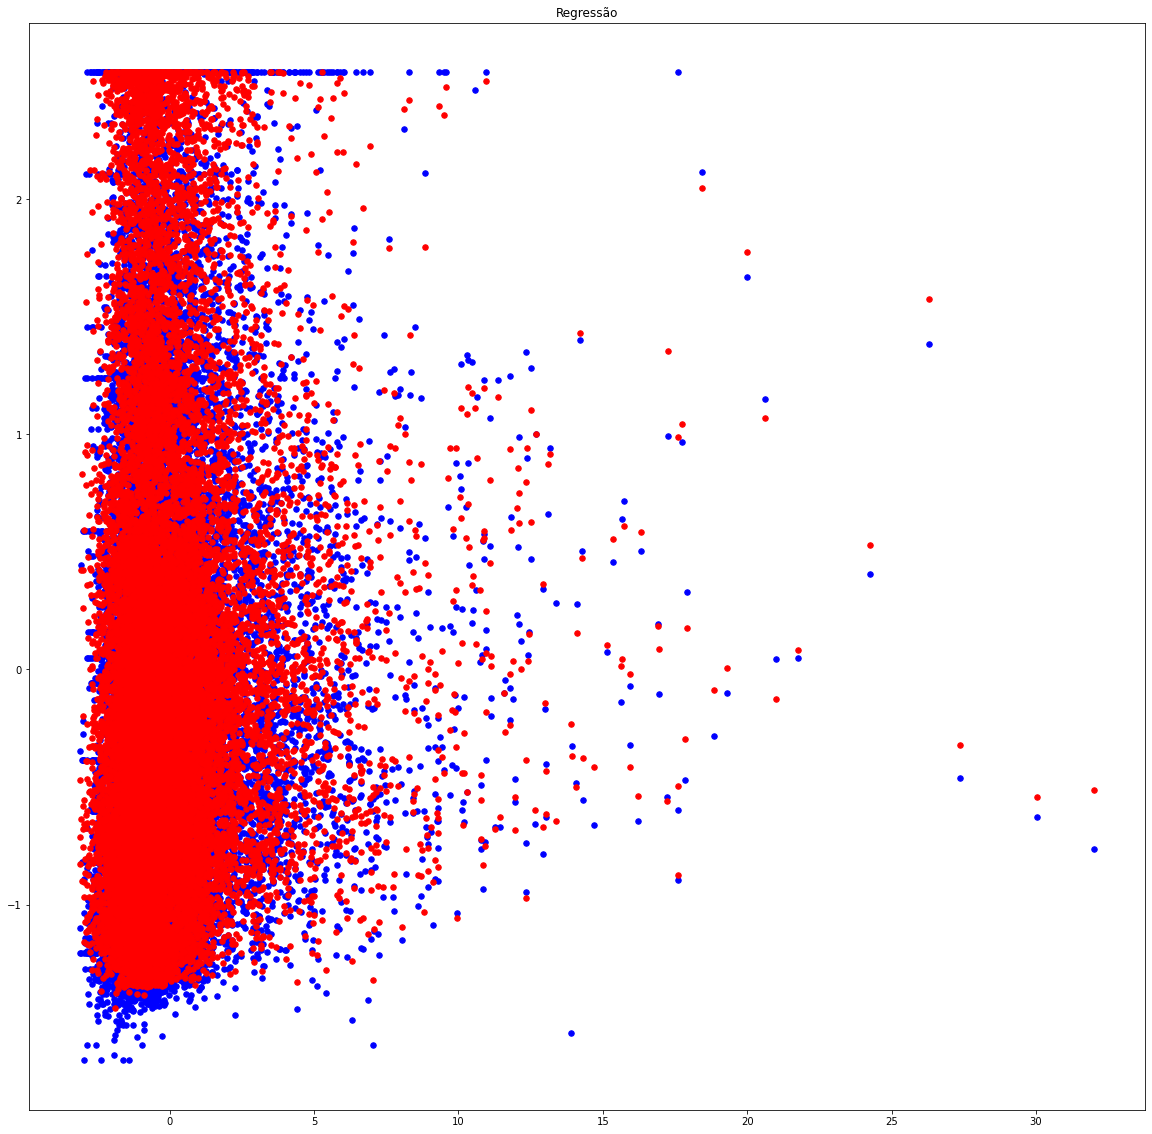

In [18]:
pca2 = PCA(n_components=1).fit_transform(X)

full_predictions = rfr.predict(X)

plt.figure(4, figsize=(20,20))
plt.scatter(pca2[:,0], data_norm['V2'], c="blue", s=30)
plt.scatter(pca2[:,0], full_predictions, c="red", s=30)

plt.title('Regressão')
plt.show();

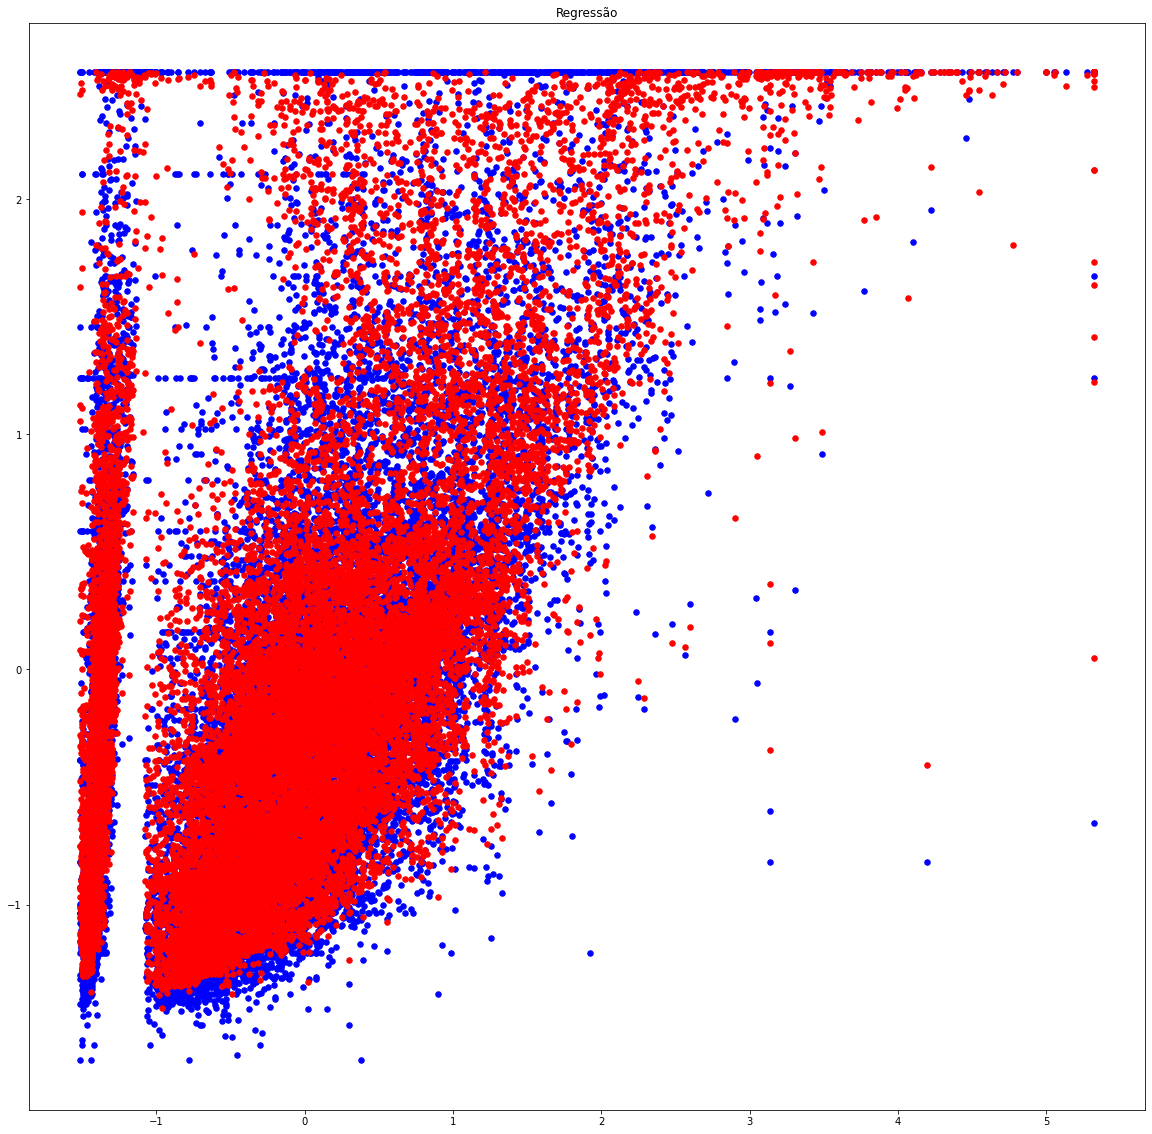

In [20]:
plt.figure(7, figsize=(20,20))
plt.scatter(data_norm['V9'], data_norm['V2'], c="blue", s=30)
plt.scatter(data_norm['V9'], full_predictions, c="red", s=30)

plt.title('Regressão')
plt.show();

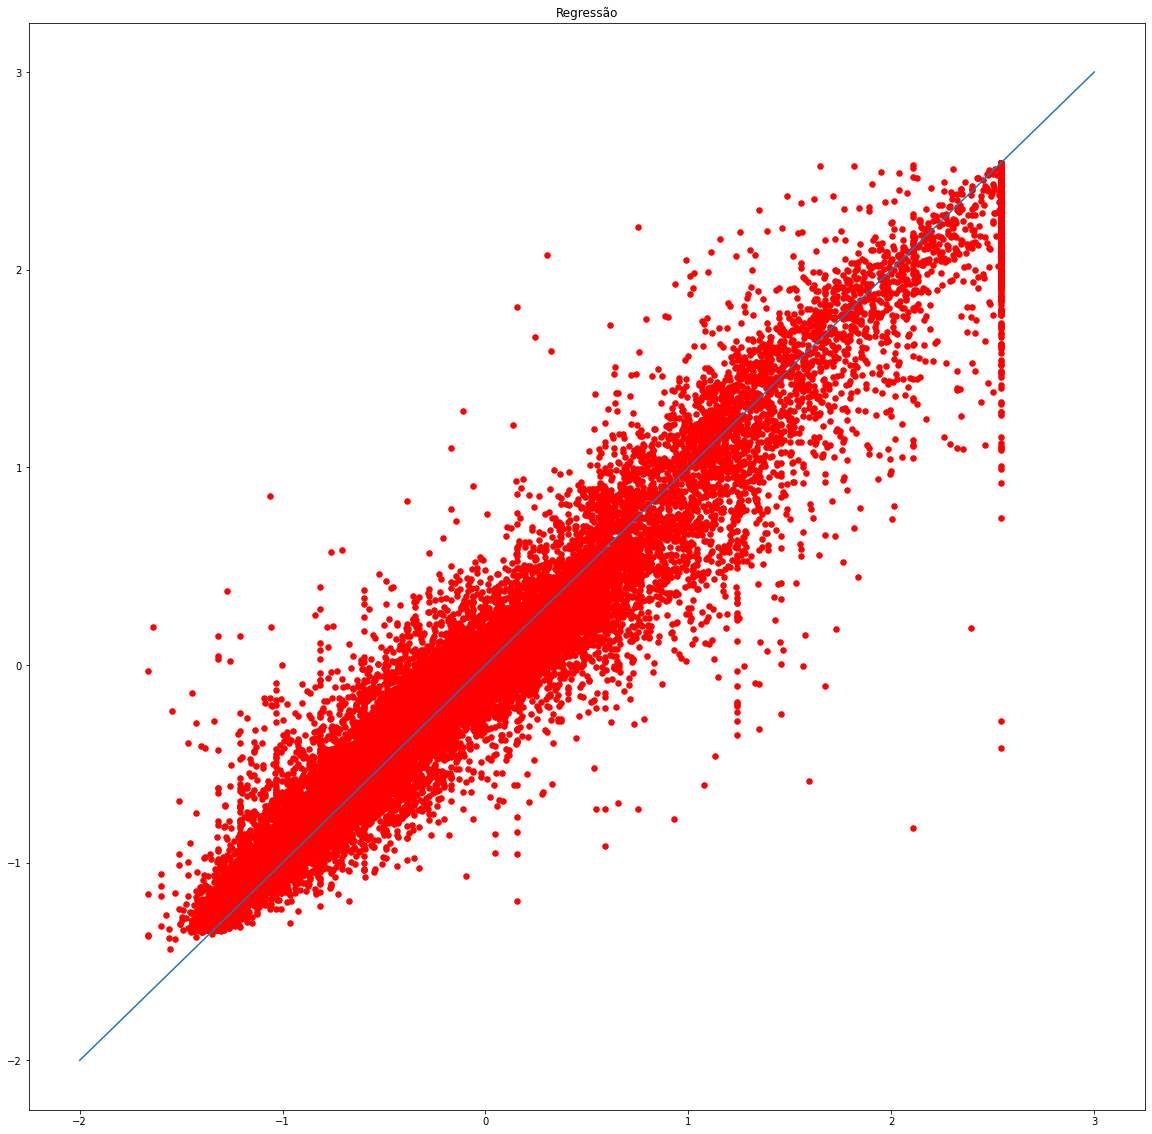

In [21]:
plt.figure(7, figsize=(20,20))
plt.scatter(data_norm['V2'], full_predictions, c="red", s=30)

t = range(-2,4)
plt.plot(t, t, linestyle='-')


plt.title('Regressão')
plt.show();